## Implementacion de Redes Neuronales – Series Temporales (LSTM)

## 1. Introduccion 
En la etapa 04 se utilizo la red neuronal MultiLayer Perceptron para datos tabulares, en este etapa 04.1 anexo implementa una arquitectura LSTM para modelar la dinamica temporal del precio promedio diario, a partir de series temporales utilizando el dataset procesado de "Calendar.csv" con el objetivo de predecir el precio de los proximos 7 dias.

## 2. Importacion de librerias y carga del dataset procesado

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,root_mean_squared_error, r2_score
import random

import torch
from torch import nn, optim

import sys
sys.path.append("..")

SEED=42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [2]:
df = pd.read_csv('../data/processed/daily_price_processed.csv')

In [3]:
df.head()

,date,price
0,2020-04-26,3238.594808
1,2020-04-27,3192.251591
2,2020-04-28,3195.983817
3,2020-04-29,3196.954992
4,2020-04-30,3183.636900


In [4]:
df['date'] = pd.to_datetime(df['date'])
df= df.sort_values('date')

df.head()

,date,price
0,2020-04-26,3238.594808
1,2020-04-27,3192.251591
2,2020-04-28,3195.983817
3,2020-04-29,3196.954992
4,2020-04-30,3183.636900


In [5]:
df['date'].diff().value_counts() # Verificar la frecuen cia de las diferencias entre fechas para confirmar que son diarias


date
1 days    364
Name: count, dtype: int64

## 3. Escalado

In [6]:
# Escalado de la columna 'price' para normalizar los valores entre 0 y 1, lo que es esencial 
# para el entrenamiento efectivo de modelos de aprendizaje profundo como LSTM.

scaler = MinMaxScaler()
price_scaled = scaler.fit_transform(df['price'].values.reshape(-1, 1)) 

## 4. Generacion de secuencia

In [7]:
from src.deep_learning.lstm  import create_sequences

seq_length = 30

X, y = create_sequences(price_scaled, seq_length) # Crear secuencias de datos para entrenamiento del modelo LSTM


## 5. Split temporal

In [8]:
split = int(len(X) * 0.85) # Dividir los datos en conjuntos de entrenamiento (85%) y prueba (15%)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


<!-- ## 6. Convertir a tensores -->

## 6.Conversion a tensores

In [9]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [10]:
X_train.shape, y_train.shape

(torch.Size([284, 30, 1]), torch.Size([284, 1]))

## 7. Instanciacion y entrenamiento del modelo

In [11]:
from src.deep_learning.lstm import LSTMModel
from src.deep_learning.lstm import train_model_lstm

In [45]:
model = LSTMModel(input_size=1, hidden_size=50)

In [46]:
model = train_model_lstm(model, X_train, y_train, epochs=150, lr=0.0007,batch_size=32)

Epoch 10, Loss: 0.031484
Epoch 20, Loss: 0.010949
Epoch 30, Loss: 0.008501
Epoch 40, Loss: 0.005265
Epoch 50, Loss: 0.004060
Epoch 60, Loss: 0.003798
Epoch 70, Loss: 0.004017
Epoch 80, Loss: 0.004314
Epoch 90, Loss: 0.003865
Epoch 100, Loss: 0.003300
Epoch 110, Loss: 0.003121
Epoch 120, Loss: 0.003053
Epoch 130, Loss: 0.003020
Epoch 140, Loss: 0.002989
Epoch 150, Loss: 0.002939


## 8. Evaluacion del modelo

In [47]:
model.eval() # Establecer el modelo en modo de evaluación para desactivar el dropout y otras capas específicas de entrenamiento

with torch.no_grad(): # Desactivar el cálculo de gradientes para la evaluación
    y_pred = model(X_test) # Realizar predicciones con el modelo entrenado

In [48]:
y_pred = y_pred.numpy() # Convertir las predicciones de PyTorch a un array de NumPy para su análisis posterior
y_test_np = y_test.numpy() # Convertir las etiquetas de prueba de PyTorch a un array de NumPy para su análisis posteriorç

y_pred = scaler.inverse_transform(y_pred) # Desescalar las predicciones para obtener los valores originales de precio
y_test_real = scaler.inverse_transform(y_test_np) # Desescalar las etiquetas de prueba para obtener los valores originales de precio

In [49]:
print("Promedio real:", y_test_real.mean())
print("Promedio pred:", y_pred.mean())

Promedio real: 4169.813
Promedio pred: 4171.9775


## 9. Metricas

In [64]:
mae_lstm = mean_absolute_error(y_test_real, y_pred)
rmse_lstm = root_mean_squared_error(y_test_real, y_pred)
r2_lstm = r2_score(y_test_real, y_pred)

print(f"MAE: {mae_lstm:.2f}")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"R2: {r2_lstm:.4f}")

MAE: 19.09
RMSE: 24.60
R2: 0.5894


## 10. Grafico real vs prediccion

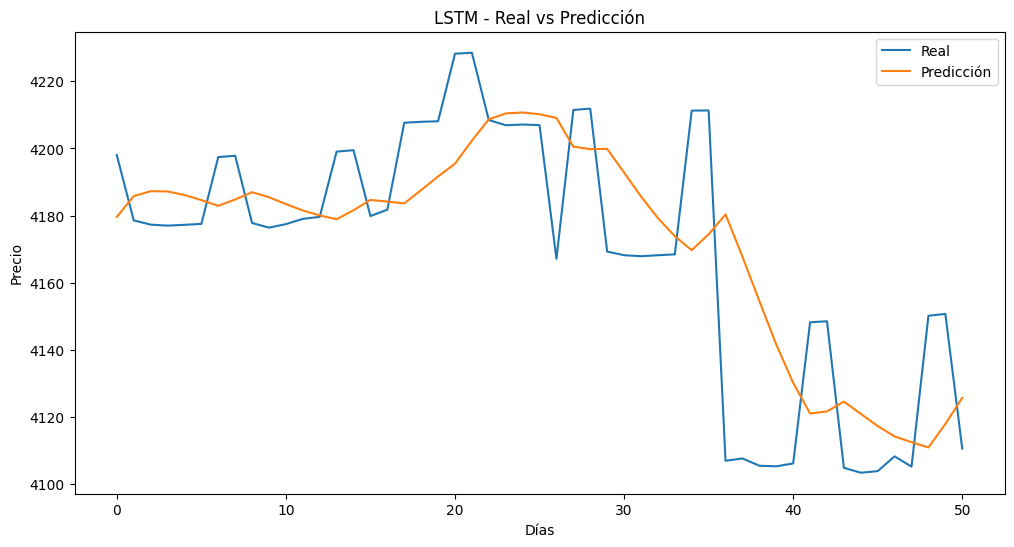

In [65]:
plt.figure(figsize=(12,6))
plt.plot(y_test_real, label="Real")
plt.plot(y_pred, label="Predicción")
plt.legend()
plt.title("LSTM - Real vs Predicción")
plt.xlabel("Días")
plt.ylabel("Precio")
plt.show()


## 11. Forecast proximos 7 dias

In [66]:
model.eval() # Establecer el modelo en modo de evaluación para desactivar el dropout y otras capas específicas de entrenamiento

# Crear la última ventana de datos para la predicción futura
last_window = torch.tensor( 
    price_scaled[-seq_length:], 
    dtype=torch.float32
).unsqueeze(0) # Agregar una dimensión adicional para que el modelo pueda procesarla correctamente

future_preds = [] # Lista para almacenar las predicciones futuras

# Realizar predicciones para los próximos 7 días utilizando la ventana deslizante
for _ in range(7):
    with torch.no_grad():
        pred = model(last_window)
    
    future_preds.append(pred.item())
    
    # Reorganizar ventana
    new_input = pred.unsqueeze(1) 
    last_window = torch.cat( 
        (last_window[:,1:,:], new_input),
        dim=1
    )


## 12. DataFrame de forecast

In [67]:
last_date = df["date"].iloc[-1] # Obtener la última fecha del DataFrame para calcular las fechas futuras

# Desescalar las predicciones futuras para obtener los valores originales de precio
future_preds = scaler.inverse_transform( 
    np.array(future_preds).reshape(-1,1)
)
# Crear un rango de fechas para los próximos 7 días a partir de la última fecha del DataFrame
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=7
)
# Crear un DataFrame para mostrar las fechas futuras y sus precios predichos
forecast_df = pd.DataFrame({
    "fecha": future_dates,
    "precio_predicho": future_preds.flatten()
})

forecast_df_display = forecast_df.copy()
forecast_df_display["fecha"] = forecast_df_display["fecha"].dt.strftime("%d/%m/%Y")
forecast_df_display["precio_predicho"] = forecast_df_display["precio_predicho"].round(2)

forecast_df_display


,fecha,precio_predicho
0,26/04/2021,4126.01
1,27/04/2021,4128.14
2,28/04/2021,4130.10
3,29/04/2021,4131.95
4,30/04/2021,4133.72
5,01/05/2021,4135.40
6,02/05/2021,4137.03


## 13. Grafico historico + forecast

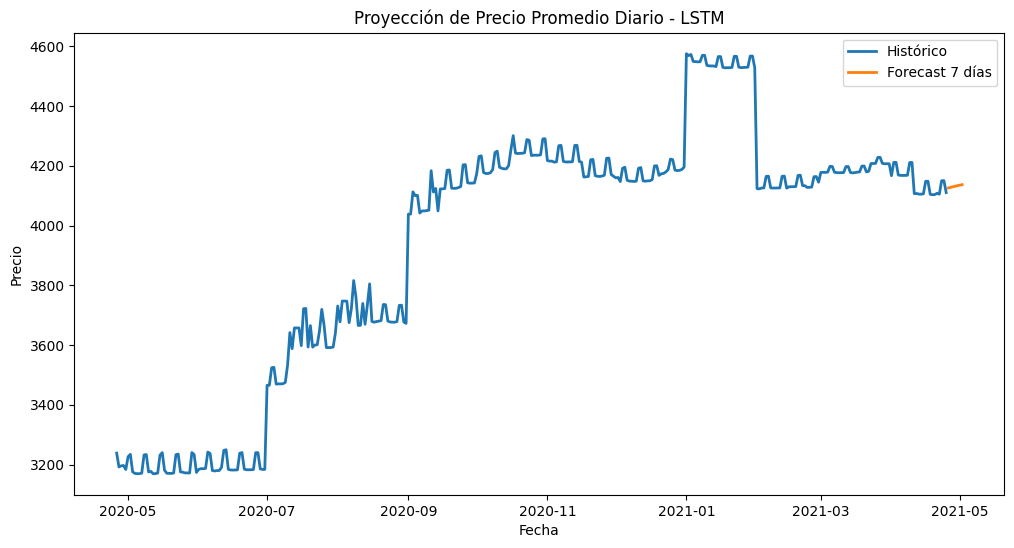

In [68]:
plt.figure(figsize=(12,6))

plt.plot(df["date"], df["price"], label="Histórico",linewidth=2)

plt.plot(
    forecast_df["fecha"],
    forecast_df["precio_predicho"],
    
    label="Forecast 7 días",
    linewidth=2,
    markersize=8
)

plt.legend()
plt.title("Proyección de Precio Promedio Diario - LSTM")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.show()

## 14. Guardado de modelo LSTM

In [69]:
# Guardar el modelo entrenado para su uso futuro sin necesidad de reentrenar
torch.save(model.state_dict(), "../models/lstm_model.pth") 

## 15. Carga del modelo 

In [70]:
model = LSTMModel(input_size=1, hidden_size=50)
model.load_state_dict(torch.load("../models/lstm_model.pth"))
model.eval()

LSTMModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)